<a href="https://colab.research.google.com/github/Framcis-A/Ejercicios/blob/main/entregablePrac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# =======================================
# CELDA 1: INSTALAR DEPENDENCIAS
# =======================================
!pip install --upgrade pip
!pip install yfinance pandas numpy matplotlib seaborn --quiet
!pip install scikit-learn torch torchvision tensorflow keras --quiet
!pip install nltk scipy kaggle --quiet

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
# =======================================
# CELDA 2: IMPORTS GLOBALES
# =======================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [9]:
# =======================================
# CELDA 3 : DESCARGAR DATOS DE MERCADO
# =======================================
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

tickers = ["AAPL", "MSFT", "AMZN"]
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Descargar datos
data = yf.download(tickers,
                   start=start_date,
                   end=end_date,
                   group_by='ticker',
                   auto_adjust=False,
                   threads=True,
                   progress=False)

# Mostrar preview de columnas
print("Preview de columnas (primeras 10):", list(data.columns[:10]))

# Extraer siempre la sección de AAPL
if isinstance(data.columns, pd.MultiIndex):
    df_raw = data['AAPL'].copy()  # solo Apple
else:
    df_raw = data.copy()

# Forzar selección de una sola columna de precio
if 'Adj Close' in df_raw.columns:
    close_series = df_raw['Adj Close'].copy()
else:
    close_series = df_raw['Close'].copy()

# Forzar serie unidimensional
close_series = close_series.squeeze()

# Si existe volumen, extraer también
volume_series = df_raw['Volume'].copy() if 'Volume' in df_raw.columns else None

# Construir DataFrame final
df = pd.DataFrame({
    'Close': close_series
})
if volume_series is not None:
    df['Volume'] = volume_series

# Calcular retornos
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

# Limpiar datos nulos
df = df.dropna()

print("Columnas finales:", df.columns.tolist())
df.head()


Preview de columnas (primeras 10): [('AMZN', 'Open'), ('AMZN', 'High'), ('AMZN', 'Low'), ('AMZN', 'Close'), ('AMZN', 'Adj Close'), ('AMZN', 'Volume'), ('AAPL', 'Open'), ('AAPL', 'High'), ('AAPL', 'Low'), ('AAPL', 'Close')]
Columnas finales: ['Close', 'Volume', 'Return', 'LogReturn']


,Close,Volume,Return,LogReturn
Date,,,,
2018-01-03,40.373978,118071600,-0.000174,-0.000174
2018-01-04,40.561493,89738400,0.004644,0.004634
2018-01-05,41.023300,94640000,0.011385,0.011321
2018-01-08,40.870934,82271200,-0.003714,-0.003721
2018-01-09,40.866241,86336000,-0.000115,-0.000115


In [12]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/14-IW23c_pJGzoKjQrbcsZJM9-mroyLAtDv-Eyk2JY6c/edit#gid=0


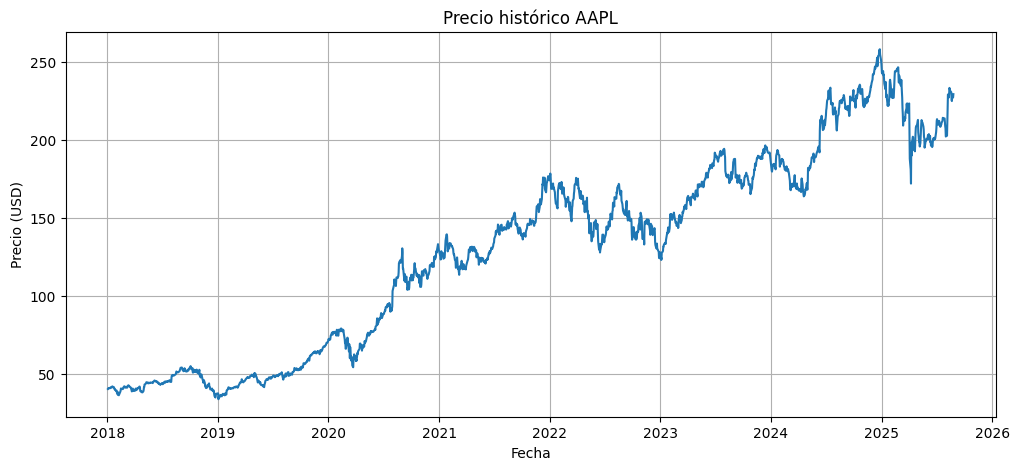

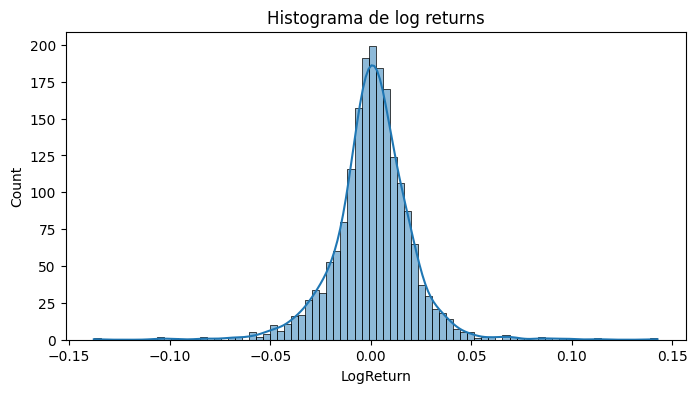

In [13]:
# =======================================
# CELDA 4: VISUALIZACIONES BÁSICAS
# =======================================
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title('Precio histórico AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['LogReturn'], bins=80, kde=True)
plt.title("Histograma de log returns")
plt.show()


In [15]:
# =======================================
# CELDA 5: FEATURE ENGINEERING Y TARGET
# =======================================
H = 5  # horizonte de días para predecir subida/bajada
df['Future'] = df['Close'].shift(-H)
df['Target'] = (df['Future'] > df['Close']).astype(int)

# features: retornos, medias móviles y volatilidad
df['MA_5'] = df['Close'].rolling(5).mean()
df['MA_21'] = df['Close'].rolling(21).mean()
df['Volatility_21'] = df['LogReturn'].rolling(21).std()
df = df.dropna()

features = ['LogReturn','MA_5','MA_21','Volatility_21']
X = df[features]
y = df['Target']

split = int(len(df)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


/tmp/ipython-input-400045064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Future'] = df['Close'].shift(-H)
/tmp/ipython-input-400045064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = (df['Future'] > df['Close']).astype(int)
/tmp/ipython-input-400045064.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [16]:
# =======================================
# CELDA 6: RANDOM FOREST (SKLEARN)
# =======================================
rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_pred = rf.predict(X_test_s)

print("RandomForest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


RandomForest Accuracy: 0.448
              precision    recall  f1-score   support

           0       0.44      0.87      0.59       169
           1       0.49      0.10      0.17       206

    accuracy                           0.45       375
   macro avg       0.47      0.49      0.38       375
weighted avg       0.47      0.45      0.36       375



In [17]:
# =======================================
# CELDA 7: RED NEURONAL  (PYTORCH)
# =======================================
Xtr = torch.tensor(X_train_s, dtype=torch.float32)
Ytr = torch.tensor(y_train.values, dtype=torch.long)
Xte = torch.tensor(X_test_s, dtype=torch.float32)
Yte = torch.tensor(y_test.values, dtype=torch.long)

train_ds = TensorDataset(Xtr, Ytr)
test_ds = TensorDataset(Xte, Yte)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

class FFNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2)
        )
    def forward(self,x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FFNet(Xtr.shape[1]).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    total_loss=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred,yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss+=loss.item()
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}")

model.eval()
preds=[]
with torch.no_grad():
    for xb,_ in test_loader:
        xb=xb.to(device)
        preds.extend(model(xb).argmax(dim=1).cpu().numpy())

print("PyTorch Accuracy:", accuracy_score(y_test, preds))


Epoch 1: loss=0.6873
Epoch 2: loss=0.6740
Epoch 3: loss=0.6680
Epoch 4: loss=0.6659
Epoch 5: loss=0.6658
Epoch 6: loss=0.6640
Epoch 7: loss=0.6633
Epoch 8: loss=0.6619
Epoch 9: loss=0.6618
Epoch 10: loss=0.6575
PyTorch Accuracy: 0.4746666666666667


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0444 - mae: 0.1479 - val_loss: 0.0056 - val_mae: 0.0656
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5530e-04 - mae: 0.0215 - val_loss: 0.0021 - val_mae: 0.0365
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7038e-04 - mae: 0.0198 - val_loss: 0.0021 - val_mae: 0.0366
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0342e-04 - mae: 0.0182 - val_loss: 0.0020 - val_mae: 0.0347
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0212e-04 - mae: 0.0203 - val_loss: 0.0025 - val_mae: 0.0399
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1639e-04 - mae: 0.0186 - val_loss: 0.0021 - val_mae: 0.0366
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3896e-04 - mae: 0.0191 - val_loss: 0.0020 - val_mae: 0.0357
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2174e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

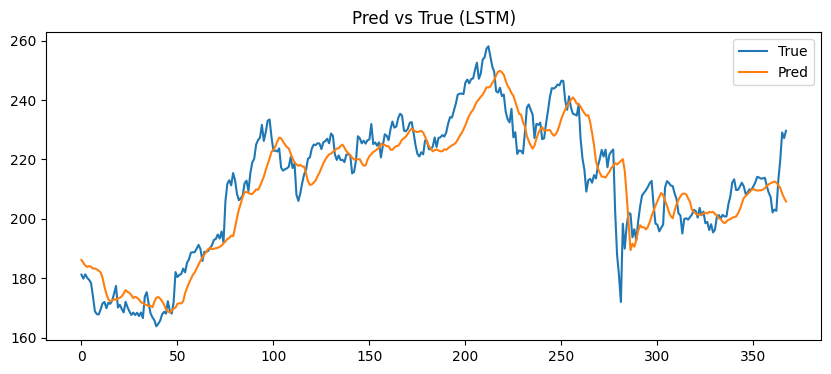

In [19]:
# =======================================
# CELDA 8: LSTM (KERAS) PARA SERIES
# =======================================
series = df[['Close']].copy()
scaler_ts = MinMaxScaler()
series_s = scaler_ts.fit_transform(series)

def create_windows(data, window=30, horizon=1):
    X, y = [], []
    for i in range(len(data)-window-horizon+1):
        X.append(data[i:i+window, 0])
        y.append(data[i+window+horizon-1, 0])
    return np.array(X), np.array(y)

W=30
X_ts, y_ts = create_windows(series_s, window=W, horizon=H)
split = int(len(X_ts)*0.8)
Xtr_ts, Xte_ts = X_ts[:split], X_ts[split:]
ytr_ts, yte_ts = y_ts[:split], y_ts[split:]

Xtr_ts = Xtr_ts.reshape((-1,W,1))
Xte_ts = Xte_ts.reshape((-1,W,1))

model_lstm = keras.Sequential([
    layers.Input(shape=(W,1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.fit(Xtr_ts, ytr_ts, validation_data=(Xte_ts,yte_ts), epochs=30, batch_size=32)

pred_s = model_lstm.predict(Xte_ts)
pred = scaler_ts.inverse_transform(pred_s)
true = scaler_ts.inverse_transform(yte_ts.reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(true, label='True')
plt.plot(pred, label='Pred')
plt.title('Pred vs True (LSTM)')
plt.legend()
plt.show()


In [23]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"escaut","key":"6558daa5e3c113436f3ad44ebe17d068"}'}

In [24]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [25]:
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
License(s): CC-BY-NC-SA-4.0
  0% 0.00/903k [00:00<?, ?B/s]
100% 903k/903k [00:00<00:00, 1.21GB/s]


In [27]:
import pandas as pd

news = pd.read_csv("/content/all-data.csv", header=None, encoding="ISO-8859-1")
news.columns = ['Sentiment', 'Headline']
news.head()


,Sentiment,Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [34]:
!pip install chardet
import chardet

with open("/content/all-data.csv", 'rb') as f:
    result = chardet.detect(f.read(10000))
print(result)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  Sentiment                                           Headline   score
0   neutral  According to Gran , the company has no plans t... -0.1280
1   neutral  Technopolis plans to develop in stages an area... -0.2960
2  negative  The international electronic industry company ...  0.0000
3  positive  With the new production plant the company woul...  0.8555
4  positive  According to the company 's updated strategy f...  0.6705


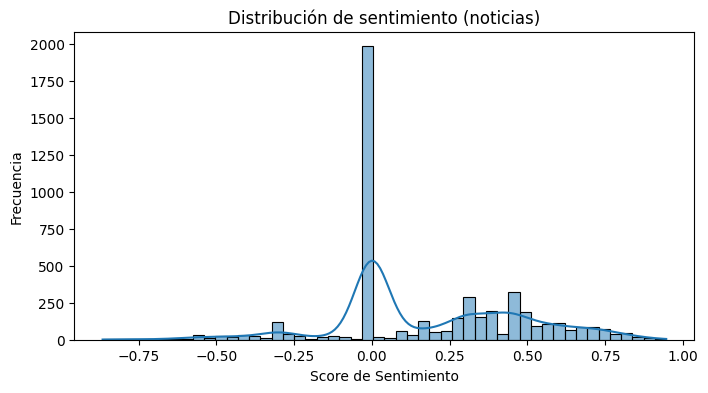

In [32]:
# =======================================
# ANALISIS DE SENTIMIENTO CON VADER (NLP)
# =======================================

# ---- 1. Importar librerías necesarias ----
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# ---- 2. Descargar recursos necesarios ----
nltk.download('vader_lexicon')

# ---- 3. Cargar el dataset de Kaggle ----
# (ya debe estar descargado y descomprimido en /content)
news = pd.read_csv("/content/all-data.csv", header=None, encoding="ISO-8859-1")
news.columns = ['Sentiment', 'Headline']

# ---- 4. Analizar sentimiento con VADER ----
sia = SentimentIntensityAnalyzer()
news['score'] = news['Headline'].apply(lambda t: sia.polarity_scores(str(t))['compound'])

# ---- 5. Ver primeras filas ----
print(news.head())

# ---- 6. Graficar distribución de sentimiento ----
plt.figure(figsize=(8,4))
sns.histplot(news['score'], bins=50, kde=True)
plt.title("Distribución de sentimiento (noticias)")
plt.xlabel("Score de Sentimiento")
plt.ylabel("Frecuencia")
plt.show()


In [33]:
# =======================================
# CELDA 10: CONCLUSIONES
# =======================================
print("""
Todo listo:
- Datos históricos descargados automáticamente
- RandomForest y PyTorch evaluados para clasificación
- LSTM entrenada para series temporales
- Análisis de sentimiento básico con VADER
""")



Todo listo:
- Datos históricos descargados automáticamente
- RandomForest y PyTorch evaluados para clasificación
- LSTM entrenada para series temporales
- Análisis de sentimiento básico con VADER

